In [80]:
##kalman szuro
import numpy as np
import matplotlib.pyplot as plt

def calib(dat):
    offset=np.array([[2.51468212, 1.63125828, 2.22166887]])#gyroscope offset

    popt=np.array([[-9.98000000e-01,  9.99999998e-04],#accelometer calibration
    [-1.00150000e+00,  7.66666673e-03],
    [-1.00500000e+00,  2.40000000e-02]])

    #magneto
    hardiron=np.array( [  30.301916, 25.042095,-113.504275])
    softiron=np.array(  [[1.110844,-0.018576, -0.054831],
        [-0.018576, 0.904965, -0.222311],
        [-0.054831 ,-0.222311,  0.616734]])



    dat[0:3]=(dat[0:3]*abs(popt[:,0])-popt[:,1])*9.807813
    dat[3:6]=np.deg2rad(dat[3:6]-offset)
    dat[6:9]=np.matmul(softiron,(dat[6:9]-hardiron))
    dat[6:9]=dat[7],-dat[6],-dat[8]
    dat[9]=dat[9]/1000
   
    return dat


def Kalman_szuro(Xk,Pk,Qk,Rk,a,Ak,Hk):
    wk=np.random.normal(0,0.01,1)
    Xk=np.dot(Ak,Xk)#+wk
  
    
    Pk=np.dot(Ak,np.dot(Pk,np.transpose(Ak)))+1*Qk
    
#mérés
    y=np.zeros(len(Xk))
    l=len(Xk)
    y[l-3:l]=a-Xk[l-3:l]
    #y=np.array([0,0,0,0,0,0,a[0]-Xk[6],a[1]-Xk[7],a[2]-Xk[8]])
    S=np.dot(Hk,np.dot(Pk,np.transpose(Hk)))+Rk
    KG=np.dot(Pk,np.dot(np.transpose(Hk),np.linalg.inv(S)))
    
    Xk+=np.dot(KG,y)
   
    Pk=np.dot((np.eye(len(Xk))-np.dot(KG,Hk)),Pk)

    return Xk,Pk


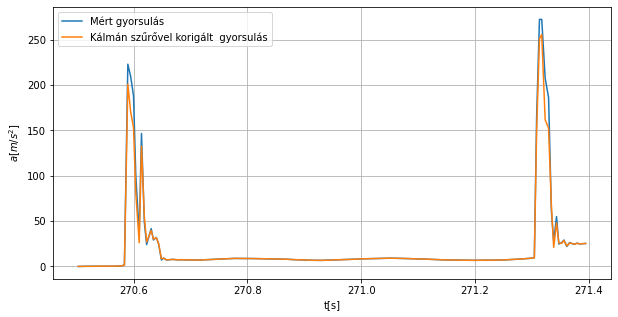

In [151]:

dataraw=np.loadtxt("d3.txt")

x=0
v=0

P=np.eye(9)
Q=np.eye(9)*0.05

var_a=0.0061#1398.4824827304847
R=np.eye(9)*var_a


H=np.eye(9)

states=np.zeros([len(dataraw[:,0]),9])
states1=np.zeros([len(dataraw[:,0]),9])
data=np.zeros([len(dataraw[:,0]),10])

data[0,:]=calib(dataraw[0,:])
X=[0,0,0,0,0,0,0,0,0]
for i in range(1,len(dataraw[:,9])):
    data[i,:]=calib(dataraw[i,:])
    
    dt=data[i,9]-data[i-1,9]

    A=np.array([[1,0,0,dt,0,0,0.5*dt**2,0,0],
            [0,1,0,0,dt,0,0,0.5*dt**2,0],
            [0,0,1,0,0,dt,0,0,0.5*dt**2],
            [0,0,0,1,0,0,dt,0,0],
            [0,0,0,0,1,0,0,dt,0],
            [0,0,0,0,0,1,0,0,dt],
            [0,0,0,0,0,0,1,0,0],
            [0,0,0,0,0,0,0,1,0],
            [0,0,0,0,0,0,0,0,1]])

    a=data[i,:3]

    v+=a*dt
    x+=v*dt
    z=np.array([x,v,a]).flatten()
    states[i,:]=z
    
    X,P=Kalman_szuro(X,P,Q,R,a,A,H)
    states1[i,:]=X




plt.figure(figsize=(10,5))

plt.plot(data[:,9],np.linalg.norm(states[:,6:9],axis=1),label="Mért gyorsulás")

plt.plot(data[:,9],np.linalg.norm(states1[:,6:9],axis=1),label="Kálmán szűrővel korigált  gyorsulás")



plt.xlabel("t[s]")
plt.ylabel("$a[m/s^2]$")
#plt.ylim(5.5,12)
#plt.xlim(270.8,271)
plt.legend()
plt.grid()

plt.show()


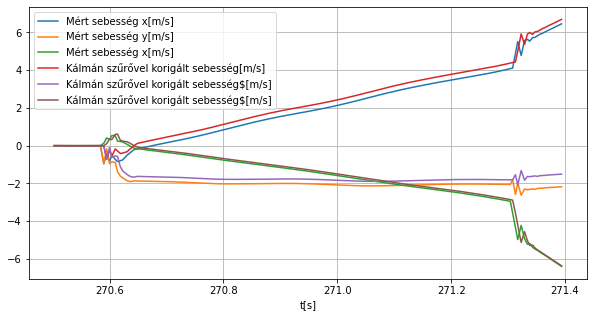

In [145]:
plt.figure(figsize=(10,5))
plt.plot(data[:,9],states[:,3],label="Mért sebesség x[m/s]")
plt.plot(data[:,9],states[:,4],label="Mért sebesség y[m/s]")
plt.plot(data[:,9],states[:,5],label="Mért sebesség x[m/s]")


plt.plot(data[:,9],states1[:,3],label="Kálmán szűrővel korigált sebesség[m/s]")
plt.plot(data[:,9],states1[:,4],label="Kálmán szűrővel korigált sebesség$[m/s]")
plt.plot(data[:,9],states1[:,5],label="Kálmán szűrővel korigált sebesség$[m/s]")
plt.xlabel("t[s]")
plt.legend()
plt.grid()

plt.show()


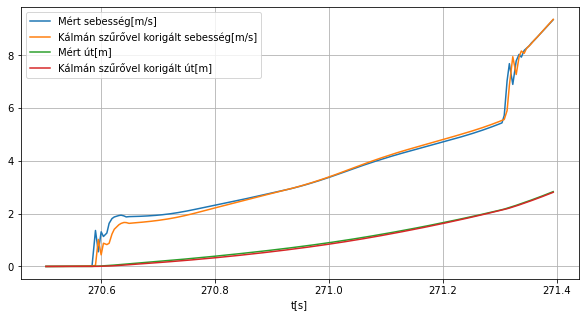

In [152]:
#hasznalj pitagor 
plt.figure(figsize=(10,5))
plt.plot(data[:,9],np.linalg.norm(states[:,3:6],axis=1),label="Mért sebesség[m/s]")

plt.plot(data[:,9],np.linalg.norm(states1[:,3:6],axis=1),label="Kálmán szűrővel korigált sebesség[m/s]")


plt.plot(data[:,9],np.linalg.norm(states[:,:3],axis=1),label="Mért út[m]")

plt.plot(data[:,9],np.linalg.norm(states1[:,:3],axis=1),label="Kálmán szűrővel korigált út[m]")
#plt.xlim(270.5,271.33)
plt.xlabel("t[s]")
plt.legend()
plt.grid()

plt.show()

NameError: name 'states0' is not defined

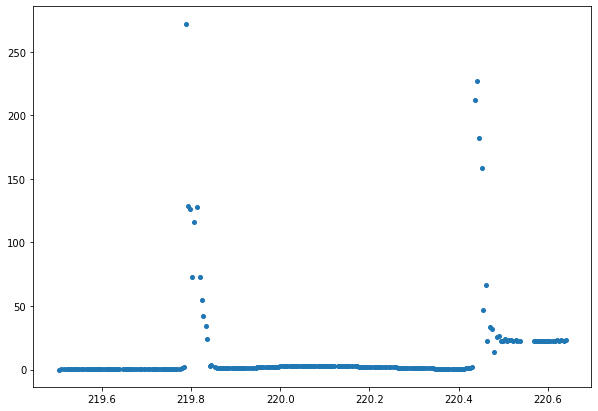

In [65]:
plt.figure(figsize=(10,7))

plt.plot(data[:,9],np.linalg.norm(states[:,6:9],axis=1),label="Mért G",marker="o",linestyle="",markersize=4)
plt.plot(data[:,9],np.linalg.norm(states0[:,6:9],axis=1),label="Kálmán szűrővel korigált G Q_diag=0.01 ",marker=".",linestyle="-",markersize=4)
plt.plot(data[:,9],np.linalg.norm(states1[:,6:9],axis=1),label="Kálmán szűrővel korigált G Q_diag=0.001 ",marker="x",linestyle="-",markersize=4)
plt.plot(data[:,9],np.linalg.norm(states2[:,6:9],axis=1),label="Kálmán szűrővel korigált G Q_diag=0.0001 ",marker="v",linestyle="-",markersize=4)
plt.plot(data[:,9],np.linalg.norm(states3[:,6:9],axis=1),label="Kálmán szűrővel korigált G Q_diag=0.00001 ",marker="s",linestyle="-",markersize=4)
plt.plot(data[:,9],np.linalg.norm(states4[:,6:9],axis=1),label="Kálmán szűrővel korigált G Q_diag=0.000001 ",marker="1",linestyle="-",markersize=4)
plt.xlabel("t[s]")
plt.ylabel("$a[m/s^2]$")
plt.ylim(9.7,9.9)
plt.xlim(39.2,39.7)
plt.legend()
plt.grid()

plt.show()


In [171]:
dataraw=np.loadtxt("g1.txt")


fi=0
X=[0,0,0,0,0,0]
P=np.zeros([6,6])

Q=np.eye(6)*0.00001

var_a=0.0017
R=np.eye(6)*var_a
#P[[3,4,5],[3,4,5]]=var_a

H=np.eye(6)

states=np.zeros([len(dataraw[:,0]),6])
states1=np.zeros([len(dataraw[:,0]),6])
data=np.zeros([len(dataraw[:,0]),10])

data[0,:]=calib(dataraw[0,:])

for i in range(1,len(dataraw[:,9])):
    data[i,:]=calib(dataraw[i,:])
    
    dt=data[i,9]-data[i-1,9]

    A=np.array([[1,0,0,dt,0,0],
            [0,1,0,0,dt,0],
            [0,0,1,0,0,dt],
            [0,0,0,1,0,0],
            [0,0,0,0,1,0],
            [0,0,0,0,0,1]])

    w=data[i,3:6]

    fi+=+w*dt
 
    z=np.array([fi,w]).flatten()
    states[i,:]=z
    
    X,P=Kalman_szuro(X,P,Q,R,w,A,H)
    states1[i,:]=X



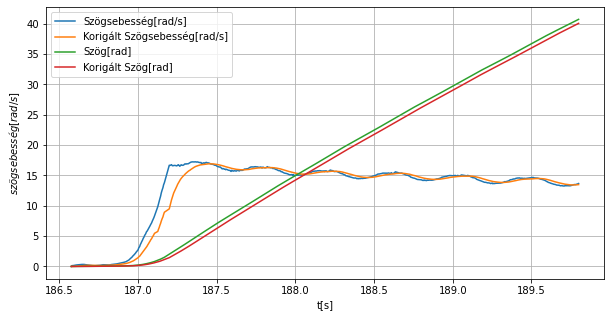

3.0147832769309253 2.9656716979289737


In [172]:
plt.figure(figsize=(10,5))

plt.plot(data[:,9],np.linalg.norm(states[:,3:6],axis=1),label="Szögsebesség[rad/s]")
plt.plot(data[:,9],np.linalg.norm(states1[:,3:6],axis=1),label="Korigált Szögsebesség[rad/s]")

plt.plot(data[:,9],np.linalg.norm(states[:,:3],axis=1),label="Szög[rad]")
plt.plot(data[:,9],np.linalg.norm(states1[:,:3],axis=1),label="Korigált Szög[rad]")

plt.xlabel("t[s]")
plt.ylabel("$szögsebesség[rad/s]$")
#plt.ylim(0,110)
#plt.xlim(293,47)
plt.legend()
plt.grid()

plt.show()
r=(np.linalg.norm(states[:,:3],axis=1).max())/(2*np.pi)*0.465
r_k=(np.linalg.norm(states1[:,:3],axis=1).max())/(2*np.pi)*0.465
print(r,r_k)

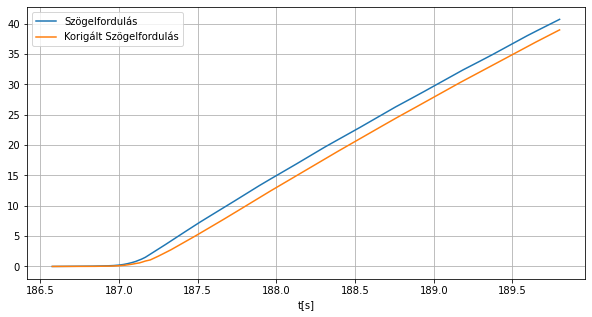

In [168]:
plt.figure(figsize=(10,5))


plt.plot(data[:,9],np.linalg.norm(states[:,:3],axis=1),label="Szögelfordulás")
plt.plot(data[:,9],np.linalg.norm(states1[:,:3],axis=1),label="Korigált Szögelfordulás")
plt.xlabel("szög[rad]")
plt.xlabel("t[s]")
#plt.ylabel("$a[m/s^2]$")
#plt.ylim(0,110)
#plt.xlim(25,50)
plt.legend()
plt.grid()

plt.show()

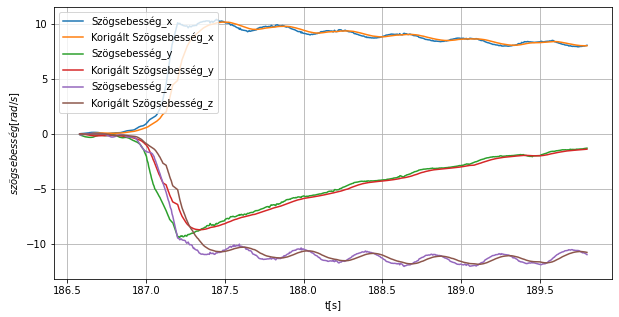

In [176]:
plt.figure(figsize=(10,5))

plt.plot(data[:,9],states[:,3],label="Szögsebesség_x")
plt.plot(data[:,9],states1[:,3],label="Korigált Szögsebesség_x")
plt.plot(data[:,9],states[:,4],label="Szögsebesség_y")
plt.plot(data[:,9],states1[:,4],label="Korigált Szögsebesség_y")
plt.plot(data[:,9],states[:,5],label="Szögsebesség_z")
plt.plot(data[:,9],states1[:,5],label="Korigált Szögsebesség_z")




plt.xlabel("t[s]")
plt.ylabel("$szögsebesség[rad/s]$")
#plt.ylim(0,110)
#plt.xlim(293,47)
plt.legend()
plt.grid()

plt.show()

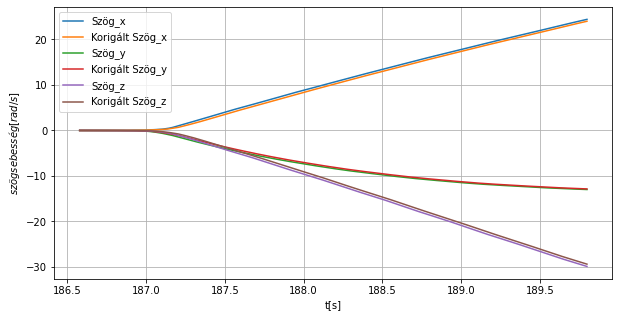

In [177]:
plt.figure(figsize=(10,5))
plt.plot(data[:,9],states[:,0],label="Szög_x")
plt.plot(data[:,9],states1[:,0],label="Korigált Szög_x")
plt.plot(data[:,9],states[:,1],label="Szög_y")
plt.plot(data[:,9],states1[:,1],label="Korigált Szög_y")
plt.plot(data[:,9],states[:,2],label="Szög_z")
plt.plot(data[:,9],states1[:,2],label="Korigált Szög_z")




plt.xlabel("t[s]")
plt.ylabel("$szögsebesség[rad/s]$")
#plt.ylim(0,110)
#plt.xlim(293,47)
plt.legend()
plt.grid()

plt.show()

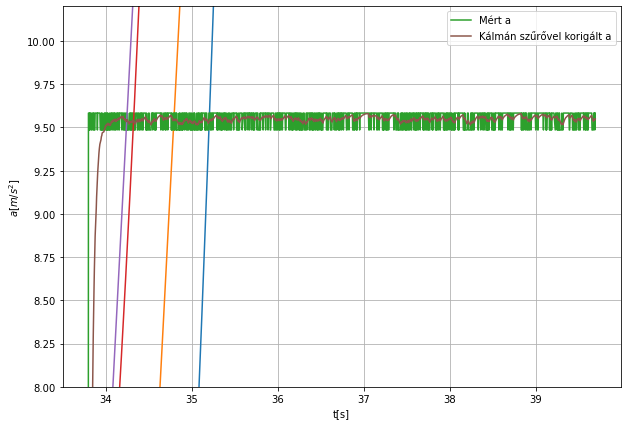

In [198]:
##kalman szuro
import numpy as np
import matplotlib.pyplot as plt

def calib(dat):
    offset=np.array([[2.51468212, 1.63125828, 2.22166887]])#gyroscope offset

    popt=np.array([[-9.98000000e-01,  9.99999998e-04],#accelometer calibration
    [-1.00150000e+00,  7.66666673e-03],
    [-1.00500000e+00,  2.40000000e-02]])

    #magneto
    hardiron=np.array( [  30.301916, 25.042095,-113.504275])
    softiron=np.array(  [[1.110844,-0.018576, -0.054831],
        [-0.018576, 0.904965, -0.222311],
        [-0.054831 ,-0.222311,  0.616734]])



    dat[0:3]=(dat[0:3]*abs(popt[:,0])-popt[:,1])*9.807813
    dat[3:6]=np.deg2rad(dat[3:6]-offset)
    dat[6:9]=np.matmul(softiron,(dat[6:9]-hardiron))
    dat[6:9]=dat[7],-dat[6],-dat[8]
    dat[9]=dat[9]/1000
   
    return dat


dataraw=np.loadtxt("labdagravit.txt")




x=0
v=0


X=[0,0,0]
P=np.ones(3)
q_var=0.0001
Q=np.array([[q_var,0,0],
           [0,q_var,0],
           [0,0,q_var],])
var_a=0.0061
R=np.array([[var_a,0,0],
            [0,var_a,0],
            [0,0,var_a]])





H=np.array([[1,0,0],[0,1,0],[0,0,1]])



states=np.zeros([len(dataraw[:,0]),3])
states2=np.zeros([len(dataraw[:,0]),3])
data=np.zeros([len(dataraw[:,0]),10])

data[0,:]=calib(dataraw[0,:])

for i in range(1,len(dataraw[:,9])):
    data[i,:]=calib(dataraw[i,:])
    
    dt=data[i,9]-data[i-1,9]

    A=np.array([[1,dt,0.5*dt**2],
            [0,1,dt],
            [0,0,1],])

    #a=np.linalg.norm(data[i,:3])
    a=data[i,0]
#predikció
    
  
    X=np.dot(A,X)
  
    
    P=np.dot(A,np.dot(P,np.transpose(A)))+1*Q
    
#mérés
  
    v+=a*dt
 
    x+=v*dt
    z=np.array([x,v,a])
    states[i,:]=z

    y=np.array([0,0,a-X[2]])
    S=np.dot(H,np.dot(P,np.transpose(H)))+R
    KG=np.dot(P,np.dot(np.transpose(H),np.linalg.inv(S)))
    
    X+=np.dot(KG,y)
   
    states2[i,:]=X
    P=np.dot((np.eye(3)-np.dot(KG,H)),P)

plt.figure(figsize=(10,7))
plt.plot(data[:,9],states[:,0])
plt.plot(data[:,9],states[:,1])
plt.plot(data[:,9],states[:,2],label="Mért a")


plt.plot(data[:,9],states2[:,0])
plt.plot(data[:,9],states2[:,1])
plt.plot(data[:,9],states2[:,2],label="Kálmán szűrővel korigált a")
plt.xlabel("t[s]")
plt.ylabel("$a[m/s^2]$")
plt.ylim(8,10.2)
#plt.xlim(40,45)
plt.legend()
plt.grid()

plt.show()


In [203]:

def Kalman_szuro(Xk,Pk,Qk,Rk,a,Ak,Hk):

#predikció
    
  
    Xk=np.dot(Ak,Xk)
  
    
    Pk=np.dot(Ak,np.dot(Pk,np.transpose(Ak)))+1*Qk
    
#mérés
  
    y=np.array([0,0,a-Xk[2]])
    S=np.dot(Hk,np.dot(Pk,np.transpose(Hk)))+Rk
    KG=np.dot(Pk,np.dot(np.transpose(Hk),np.linalg.inv(S)))
    
    Xk+=np.dot(KG,y)
   
    Pk=np.dot((np.eye(3)-np.dot(KG,H)),P)


    return Xk,Pk



dataraw=np.loadtxt("labdagravit.txt")




x=0
v=0
H=np.array([[1,0,0],[0,1,0],[0,0,1]])

ax=[0,0,0]
Px=np.ones(3)
ay=[0,0,0]
Py=np.ones(3)
az=[0,0,0]
Pz=np.ones(3)
q_var=0.0001
Q=np.array([[q_var,0,0],
           [0,q_var,0],
           [0,0,q_var],])

var_a=0.0061
R=np.array([[var_a,0,0],
            [0,var_a,0],
            [0,0,var_a]])









states=np.zeros([len(dataraw[:,0]),3])
states1=np.zeros([len(dataraw[:,0]),3])
data=np.zeros([len(dataraw[:,0]),10])

data[0,:]=calib(dataraw[0,:])

for i in range(1,len(dataraw[:,9])):
    data[i,:]=calib(dataraw[i,:])
    
    dt=data[i,9]-data[i-1,9]

    A=np.array([[1,dt,0.5*dt**2],
            [0,1,dt],
            [0,0,1],])
    
    a=data[i,:3]
    v+=a*dt
    x+=v*dt
    z=np.array([x[0],v[0],a[0]])
    states[i,:]=z
    ax,Px=Kalman_szuro(ax,Px,Q,R,a[0],A,H)
    ay,Py=Kalman_szuro(ay,Py,Q,R,a[1],A,H)
    az,Pz=Kalman_szuro(az,Pz,Q,R,a[2],A,H)
    states1[i,:]=ax

    

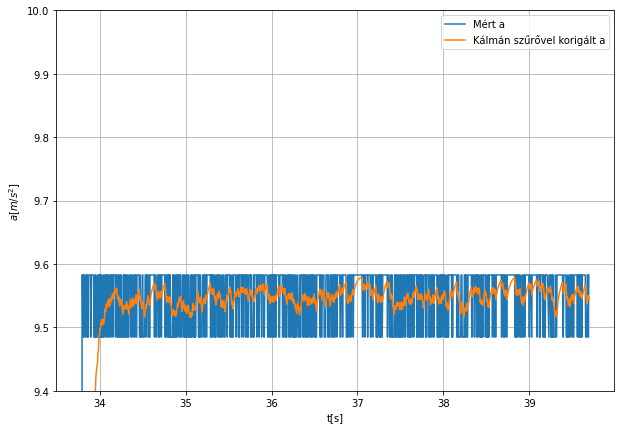

In [204]:
plt.figure(figsize=(10,7))
#plt.plot(data[:,9],states[:,0])
#plt.plot(data[:,9],states[:,1])
plt.plot(data[:,9],states[:,2],label="Mért a")


#plt.plot(data[:,9],states1[:,0])
#plt.plot(data[:,9],states1[:,1])
plt.plot(data[:,9],states1[:,2],label="Kálmán szűrővel korigált a")
plt.xlabel("t[s]")
plt.ylabel("$a[m/s^2]$")
plt.ylim(9.4,10)
#plt.xlim(40,45)
plt.legend()
plt.grid()

plt.show()
